In [50]:
import requests
import gzip
import numpy as np
import pandas as pd
from Bio import SeqIO
from sklearn.model_selection import train_test_split

In [8]:
df = pd.read_feather('./master_dataset.ftr')

In [78]:
df

,dhs_id,chr,start,end,DHS_width,summit,numsamples,total_signal,component,proportion,...,fKidney_ENCLB005SRL,fKidney_ENCLB704GMQ,fKidney_ENCLB759USM,fLung_ENCLB594BSZ,fKidney_ENCLB049MNH,fUmbilical_cord_ENCLB771UER,fBone_femur_ENCLB236BWV,fLiver_ENCLB638FEH,fPlacenta_ENCLB423VBC,fPlacenta_ENCLB711ZZZ
0,chr1_16140_16200_16170,chr1,16140,16200,60,16170,1,0.129388,1,0.855153,...,0,0,0,0,0,0,0,0,0,0
1,chr1_51868_52040_51970,chr1,51868,52040,172,51970,1,0.080034,7,0.973545,...,0,0,0,0,0,0,0,0,0,0
2,chr1_57280_57354_57350,chr1,57280,57354,74,57350,4,1.093002,8,1.000000,...,0,0,0,0,0,0,0,0,0,0
3,chr1_66370_66482_66430,chr1,66370,66482,112,66430,8,1.469725,3,0.332213,...,0,0,0,0,0,0,0,0,0,0
4,chr1_79100_79231_79150,chr1,79100,79231,131,79150,2,0.226098,7,0.501840,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3591893,chrY_56882540_56882719_56882610,chrY,56882540,56882719,179,56882610,1,0.038079,5,0.803229,...,0,0,0,0,0,0,0,0,0,0
3591894,chrY_56882864_56882980_56882930,chrY,56882864,56882980,116,56882930,1,0.115489,5,0.742349,...,0,0,0,0,0,0,0,0,0,0
3591895,chrY_56883733_56883960_56883830,chrY,56883733,56883960,227,56883830,5,2.456885,7,0.559734,...,0,0,0,0,0,0,0,0,0,0
3591896,chrY_56884440_56884580_56884510,chrY,56884440,56884580,140,56884510,1,0.053759,5,0.803229,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df.head()

,dhs_id,chr,start,end,DHS_width,summit,numsamples,total_signal,component,proportion,...,fKidney_ENCLB005SRL,fKidney_ENCLB704GMQ,fKidney_ENCLB759USM,fLung_ENCLB594BSZ,fKidney_ENCLB049MNH,fUmbilical_cord_ENCLB771UER,fBone_femur_ENCLB236BWV,fLiver_ENCLB638FEH,fPlacenta_ENCLB423VBC,fPlacenta_ENCLB711ZZZ
0,chr1_16140_16200_16170,chr1,16140,16200,60,16170,1,0.129388,1,0.855153,...,0,0,0,0,0,0,0,0,0,0
1,chr1_51868_52040_51970,chr1,51868,52040,172,51970,1,0.080034,7,0.973545,...,0,0,0,0,0,0,0,0,0,0
2,chr1_57280_57354_57350,chr1,57280,57354,74,57350,4,1.093002,8,1.000000,...,0,0,0,0,0,0,0,0,0,0
3,chr1_66370_66482_66430,chr1,66370,66482,112,66430,8,1.469725,3,0.332213,...,0,0,0,0,0,0,0,0,0,0
4,chr1_79100_79231_79150,chr1,79100,79231,131,79150,2,0.226098,7,0.501840,...,0,0,0,1,0,0,0,0,0,0


In [74]:
class FilteringData:
    def __init__(self, df: pd.DataFrame, cell_list: list):
        self.df = df
        self.cell_list = cell_list
        self._test_data_structure()

    def _test_data_structure(self):
        # Ensures all columns after the 11th are named cell names
        assert all('_ENCL' in x for x in self.df.columns[11:]), '_ENCL not in all columns after 11th'

    def filter_exclusive_replicates(self, sort: bool = False, balance: bool = True):
        """Given a specific set of samples (one per cell type),
        capture the exclusive peaks of each sample (the ones matching just one sample for the whole set)
        and then filter the dataset to keep only these peaks.
        
        Additionally, return an equal number of non-exclusive peaks as negative cases.

        Returns:
            pd.DataFrame: The original dataframe plus columns for each cell type with the exclusive peaks and negative cases
        """
        print('Filtering exclusive peaks between replicates')
        # Selecting the columns corresponding to the cell types
        subset_cols = self.df.columns[:11].tolist() + self.cell_list
        # Creating a new dataframe with only the columns corresponding to the cell types
        df_subset = self.df[subset_cols]
        # Creating a new column for each cell type with the exclusive peaks or 'NO_TAG' if not exclusive
        df_subset['TAG'] = df_subset[self.cell_list].apply(lambda x: 'NO_TAG' if x.sum() != 1 else x.idxmax(), axis=1)

        # Creating a new dataframe with only the rows with exclusive peaks
        new_df_list = []
        for k, v in df_subset.groupby('TAG'):
            if k != 'NO_TAG':
                cell, replicate = '_'.join(k.split('_')[:-1]), k.split('_')[-1]
                v['additional_replicates_with_peak'] = (
                    self.df[self.df.filter(like=cell).columns].apply(lambda x: x.sum(), axis=1) - 1
                )
                temp_df = self.df.filter(like=cell)
                print(f'Cell type: {cell}, Replicate: {replicate}, Number of exclusive peaks: {v.shape[0]}')
            else:
                v['additional_replicates_with_peak'] = 0
            new_df_list.append(v)
        new_df = pd.concat(new_df_list).sort_index()
        new_df['other_samples_with_peak_not_considering_reps'] = (
            new_df['numsamples'] - new_df['additional_replicates_with_peak'] - 1
        )

        # Sorting the dataframe by the number of samples with the peak
        if sort:
            new_df = pd.concat(
                [
                    x_v.sort_values(
                        by=['additional_replicates_with_peak', 'other_samples_with_peak_not_considering_reps'],
                        ascending=[False, True],
                    )
                    for x_k, x_v in new_df.groupby('TAG')
                ],
                ignore_index=True,
            )

        # Balancing the dataset
        if balance:
            lowest_peak_count = new_df.groupby('TAG').count()['sequence'].min()
            new_df = pd.concat(
                [v_bal.head(lowest_peak_count) for k_bal, v_bal in new_df.groupby('TAG') if k_bal != 'NO_TAG']
            )

        # Adding negative cases
        # negative_cases = df_subset[df_subset['TAG'] == 'NO_TAG']
        # if balance:
        #     negative_cases = negative_cases.sample(n=new_df.shape[0], random_state=1)
        # new_df = pd.concat([new_df, negative_cases])

        return new_df


In [88]:
cell_list = ['HepG2_ENCLB480ZZZ', 'Hela_ENCLB479ZZZ', 'K562_ENCLB540ZZZ', 'MCF7_ENCLB554ZZZ',
        'GM12878_ENCLB440ZZZ', 'HUVEC_ENCLB533ZZZ', 'NHEK_ENCLB568ZZZ',
        'HESC_ENCLB442ZZZ', 'H7_hESC_T5_ENCLB445ZZZ',
        'fBrain_ENCLB217VMW', 'fLung_ENCLB183OTV', 'fHeart_ENCLB740GHK',
        'Jurkat_ENCLB538ZZZ', 'CD34_ENCLB064DTW']

In [107]:
filtered_df = FilteringData(
    df, cell_list=cell_list
).filter_exclusive_replicates(sort=True, balance=False)

Filtering exclusive peaks between replicates


/tmp/ipykernel_2436207/4000505870.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['TAG'] = df_subset[self.cell_list].apply(lambda x: 'NO_TAG' if x.sum() != 1 else x.idxmax(), axis=1)


Cell type: CD34, Replicate: ENCLB064DTW, Number of exclusive peaks: 7053
Cell type: GM12878, Replicate: ENCLB440ZZZ, Number of exclusive peaks: 6491
Cell type: H7_hESC_T5, Replicate: ENCLB445ZZZ, Number of exclusive peaks: 16534
Cell type: HESC, Replicate: ENCLB442ZZZ, Number of exclusive peaks: 5273
Cell type: HUVEC, Replicate: ENCLB533ZZZ, Number of exclusive peaks: 69719
Cell type: Hela, Replicate: ENCLB479ZZZ, Number of exclusive peaks: 12663
Cell type: HepG2, Replicate: ENCLB480ZZZ, Number of exclusive peaks: 31485
Cell type: Jurkat, Replicate: ENCLB538ZZZ, Number of exclusive peaks: 32483
Cell type: K562, Replicate: ENCLB540ZZZ, Number of exclusive peaks: 42577
Cell type: MCF7, Replicate: ENCLB554ZZZ, Number of exclusive peaks: 15056
Cell type: NHEK, Replicate: ENCLB568ZZZ, Number of exclusive peaks: 16593
Cell type: fBrain, Replicate: ENCLB217VMW, Number of exclusive peaks: 164508
Cell type: fHeart, Replicate: ENCLB740GHK, Number of exclusive peaks: 4280
Cell type: fLung, Replic

In [84]:
len(filtered_df)

59920

In [82]:
set(filtered_df.TAG), len(set(filtered_df.TAG))

({'CD34_ENCLB064DTW',
  'GM12878_ENCLB440ZZZ',
  'H7_hESC_T5_ENCLB445ZZZ',
  'HESC_ENCLB442ZZZ',
  'HUVEC_ENCLB533ZZZ',
  'Hela_ENCLB479ZZZ',
  'HepG2_ENCLB480ZZZ',
  'Jurkat_ENCLB538ZZZ',
  'K562_ENCLB540ZZZ',
  'MCF7_ENCLB554ZZZ',
  'NHEK_ENCLB568ZZZ',
  'fBrain_ENCLB217VMW',
  'fHeart_ENCLB740GHK',
  'fLung_ENCLB183OTV'},
 14)

In [83]:
filtered_df.TAG.describe()

count                59920
unique                  14
top       CD34_ENCLB064DTW
freq                  4280
Name: TAG, dtype: object

In [85]:
filtered_df.to_csv('filtered_data_with_labels_14_biosamples.csv', index=False)

In [87]:
filtered_df.head()

,dhs_id,chr,start,end,DHS_width,summit,numsamples,total_signal,component,proportion,...,HESC_ENCLB442ZZZ,H7_hESC_T5_ENCLB445ZZZ,fBrain_ENCLB217VMW,fLung_ENCLB183OTV,fHeart_ENCLB740GHK,Jurkat_ENCLB538ZZZ,CD34_ENCLB064DTW,TAG,additional_replicates_with_peak,other_samples_with_peak_not_considering_reps
0,chr10_98361340_98361600_98361490,chr10,98361340,98361600,260,98361490,47,95.535458,15,0.621214,...,0,0,0,0,0,0,1,CD34_ENCLB064DTW,29,17
1,chr9_123035178_123035400_123035270,chr9,123035178,123035400,222,123035270,47,207.760350,15,0.608076,...,0,0,0,0,0,0,1,CD34_ENCLB064DTW,29,17
2,chr6_166718160_166718360_166718270,chr6,166718160,166718360,200,166718270,50,136.698466,15,0.555789,...,0,0,0,0,0,0,1,CD34_ENCLB064DTW,29,20
3,chr1_247852740_247852900_247852830,chr1,247852740,247852900,160,247852830,64,226.367137,15,0.503678,...,0,0,0,0,0,0,1,CD34_ENCLB064DTW,29,34
4,chr20_4155004_4155277_4155130,chr20,4155004,4155277,273,4155130,64,668.691889,15,0.490764,...,0,0,0,0,0,0,1,CD34_ENCLB064DTW,29,34


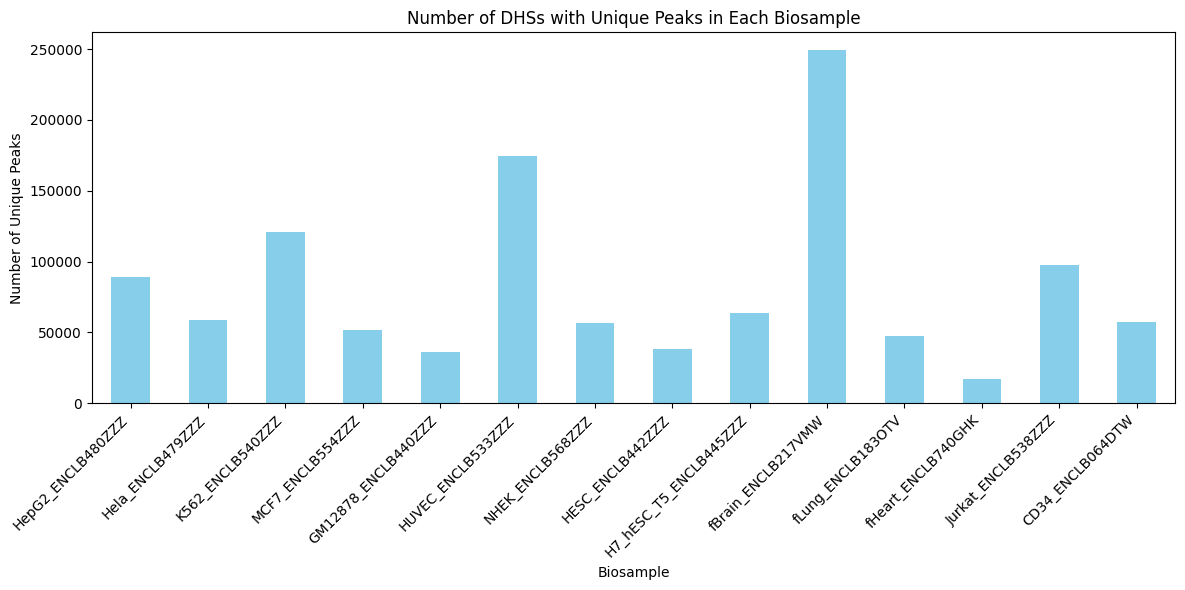

In [109]:

import matplotlib.pyplot as plt
# List of the 14 biosample columns
biosample_columns = [
    'HepG2_ENCLB480ZZZ', 'Hela_ENCLB479ZZZ', 'K562_ENCLB540ZZZ', 'MCF7_ENCLB554ZZZ',
    'GM12878_ENCLB440ZZZ', 'HUVEC_ENCLB533ZZZ', 'NHEK_ENCLB568ZZZ',
    'HESC_ENCLB442ZZZ', 'H7_hESC_T5_ENCLB445ZZZ',
    'fBrain_ENCLB217VMW', 'fLung_ENCLB183OTV', 'fHeart_ENCLB740GHK',
    'Jurkat_ENCLB538ZZZ', 'CD34_ENCLB064DTW'
]

# Count the number of unique peaks (DHSs) in each biosample
unique_peaks_counts = filtered_df[biosample_columns].sum()

# Plot the histogram
plt.figure(figsize=(12, 6))
unique_peaks_counts.plot(kind='bar', color='skyblue')
plt.title('Number of DHSs with Unique Peaks in Each Biosample')
plt.xlabel('Biosample')
plt.ylabel('Number of Unique Peaks')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('./hist.pdf', format='pdf')
plt.show()

In [89]:
tissue_to_label = {}
for i, name in enumerate(cell_list):
    tissue_to_label[name] = i

In [90]:
tissue_to_label

{'HepG2_ENCLB480ZZZ': 0,
 'Hela_ENCLB479ZZZ': 1,
 'K562_ENCLB540ZZZ': 2,
 'MCF7_ENCLB554ZZZ': 3,
 'GM12878_ENCLB440ZZZ': 4,
 'HUVEC_ENCLB533ZZZ': 5,
 'NHEK_ENCLB568ZZZ': 6,
 'HESC_ENCLB442ZZZ': 7,
 'H7_hESC_T5_ENCLB445ZZZ': 8,
 'fBrain_ENCLB217VMW': 9,
 'fLung_ENCLB183OTV': 10,
 'fHeart_ENCLB740GHK': 11,
 'Jurkat_ENCLB538ZZZ': 12,
 'CD34_ENCLB064DTW': 13}

In [91]:
filtered_df['label'] = filtered_df['TAG'].map(tissue_to_label)

In [92]:
filtered_df_seq_label = filtered_df[['sequence', 'label']]
filtered_df_seq_label

,sequence,label
0,ATAATAAACGTTTTGGAGTCATTCGTAACACAGCAAGTGATAATGA...,13
1,CTTATTGTCTGCTTCACCTATTTCAACATCTTCCGCATCTGCCAAC...,13
2,TTCTATGAAGGCAAAAGCAACTGTGCACATTTACCCTCACTTCCCC...,13
3,GAAAAAAATGCAGGGTTCAGTTGCGTGAATGAGGTCCTTTTAAAGC...,13
4,ACGAGGGGGTATCTTGGGTGACTGTATCCCGGGGCAGGGTGACATG...,13
...,...,...
3586455,TCTTGACCTTGTGATCTGCCCGCCTCGGCCTCCCAAAGAGCTGGGA...,10
3586456,CTTGTGTTACTTCTCCCCTGATTCTTCCCTTGGGGTGGACTGTTGA...,10
3586457,CAAAAACTGTGCCATCAGCGCAAGACCCTGTGATTTCTGTGGTATT...,10
3586458,ACAACGCTGTGATGAGAATCTTTGTATATAAATATTTGTGCATCTC...,10


In [96]:
# Set random seed for reproducibility
random_seed = 42

# Split the dataset into training set (80%) and temporary set (20%)
train_df, temp_df = train_test_split(filtered_df_seq_label, test_size=0.2, random_state=random_seed, stratify=filtered_df['label'])

# Further split the temporary set into validation set (50%) and test set (50%)
dev_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=random_seed, stratify=temp_df['label'])

In [97]:
# Add column names
train_df.columns = ['sequence', 'label']
dev_df.columns = ['sequence', 'label']
test_df.columns = ['sequence', 'label']

# Save the datasets to CSV files
train_df.to_csv('train.csv', index=False)
dev_df.to_csv('dev.csv', index=False)
test_df.to_csv('test.csv', index=False)

print("Datasets have been successfully saved as train.csv, dev.csv, and test.csv")

# Print the first few rows to verify the format
print(train_df.head())
print(dev_df.head())
print(test_df.head())

Datasets have been successfully saved as train.csv, dev.csv, and test.csv
                                                  sequence  label
34093    AAATGCTATCTATGGAGTACCTGAATAGCTGAGGCATTTAAAGCAT...      7
3413402  TAAAAAGAGAAGAATTTGCCCCCAGTTTTGTTACCATTTTCCTTCA...      9
149882   TGATCTCTGCTTCAACTGTCACATCTCCTCAGTTTCTCCCACCTCC...     12
36076    TTTTGCAACTAAGTTATTTGTTGTTTCCATTTAGTGCTCTTCCTCT...      5
183737   AAATTCCCCTTTATAAAACCATCAGATCTCATGAGACTTACTCACT...      2
                                                  sequence  label
17149    AGTGGGACGGGCCTAGGGCTGCAGCCCCACTGGTAATGGGCTGTTC...      8
13881    CAACTATTGGGCAACTATTATCACCTTTCCTCTCTCTCTCTATCTG...      8
184571   AAGCCTATCGCTGTCTCCCTGCTGGCCCCTGAGGAGAGCGCTGAAA...      2
3413691  AGGCAGTTCCAGTGGAGTCTGCAGGGTTCACTCTTTCCTTCCCTCT...      9
39154    CTCCAAGACAGGGATCATAGGAAGCTTGTAACCTTGGAAAAATCCC...      5
                                                  sequence  label
118506   GAGGAAGAGGCAACAATTTTATGCATGTTAGACAAACAAATCACAC...      0
18

In [103]:
len(train_df), len(dev_df), len(test_df)

(47936, 5992, 5992)

In [102]:
set(train_df.label), set(dev_df.label), set(test_df.label)

({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13},
 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13},
 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13})